In [96]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# plt.style.use('max_style.mplstyle')

from numba.experimental import jitclass
import numba as nb
from scipy.interpolate import interp1d

from tqdm import tqdm
from time import time
from spl import spline
from scipy.optimize import minimize

%matplotlib inline

## Table of contents:
* [Define Verlet and System Base Class](#first-bullet)
    * [load trap geometry](#load-trap-geometry)
* [Test system with "theory" ramps](#Test-system-with-theory-ramps)
    * [rescale excitation energy from eV to n$\hbar\omega$](#rescale)
    * [Plot result](#restheory)
* [Test system with Janines ramps](#janiramps)
    * [Single Transport](#singt)
    * [Plot result](#resjanine)
    * [investigate high excitation regions](#investigate)
* [Introduce a filter compensation](#filtercomp)


# <center>Define Verlet and System Base Class</center><a id="first-bullet"></a>

In [97]:
class verlet():
    def getAcc(self, positions, _):
        """
        simple harmonic oscillator.
        This is for testing purposes. The user should 
        overload this function in order to implement the system
        that should be simulated. 
        (like multiple ions interact with eachother)
        """
        
        return -positions
    
    def integrate(self, endtime, dt):
        """
        calculate the trajectory for N Ions in M Dimensions.
        implemented shortened velocity verlet from:
        https://en.wikipedia.org/wiki/Verlet_integration
        assumes, that acceleration only depends on position.

        Parameters
        ----------
        self.getAcc : function(array) : array
            verlet integrates only, so acceleration function
            needs to implemented by the user!
            see getAcc docstring

        endtime : float
            Seconds on where to end simulation.

        dt : float
            step size between each evaluation step in Seconds.
            With our setup of iontraps less or equal to
            5e-9 is recommended! (redtrap)

        Returns
        -------
        tpoints : np.array
            points of all evaluated timesteps

        ppoints : np.array
            ppoints[:, 0, 0, 0]
                    |  |  |  |
                    |  |  |  > dimension x (or general 1st dim)
                    |  |  > 0 is position, 
                    |  |    1 velocity, 2 acceleration
                    |  > choose ion #0
                    > all timesteps
        """

        n = int(endtime / dt)
        shape = (n,) + self.ions.shape
        tpoints = np.linspace(0, endtime, n)
        ppoints = np.empty(shape, dtype=np.float64)

        ppoints[0] = self.ions

        # iterate through all timepoints, see wiki link in docstring
        for k in range(len(tpoints)-1):
            ppoints[k+1, :, 0] = ppoints[k, :, 0] + ppoints[k, :, 1] * dt + 0.5 * ppoints[k, :, 2] * dt**2
            ppoints[k+1, :, 2] = self.getAcc(ppoints[k+1, :, 0, 0], k+1)
            ppoints[k+1, :, 1] = ppoints[k, :, 1] + 0.5 * (ppoints[k, :, 2] + ppoints[k+1, :, 2]) * dt

        return tpoints, ppoints

In [98]:
spec = [('ions', nb.float64[:, :, :]),
        ('trap', nb.float64[:, :, :]),
        ('splcoeff', nb.float64[:, :, :]),
        ('volt', nb.float64[:, :]),
        ('qdm', nb.float64),]

@jitclass(spec)
class red_system(verlet, spline):
    def __init__(self, trap):
        
        self.splcoeff = np.empty(trap.shape)
        
        for i in range(len(trap)):
            self.splcoeff[i, 0] = self.splrep(trap[i, 0], trap[i, 1])
            self.splcoeff[i, 1] = self.splrep(trap[i, 0], trap[i, 2])
        
        self.trap = trap
        
        q = 1.60217662e-19
        m = 1.66054e-27*39.96259
        self.qdm = q/m
        
    def propagate(self, ramp, endtime, dt):
        n = int(endtime / dt)
        tpoints = np.linspace(0, endtime, n)
        
        self.volt = np.zeros((len(ramp)-1, n))
        for i in range(len(ramp)-1):
            self.volt[i] = np.interp(tpoints, ramp[0], ramp[i+1])
        
        return self.integrate(endtime, dt)
        
    def setIons(self, positions):
        """
        set the initial positions of the ions.
        
        Parameters
        ----------
        posistions : np.array
            has size (#numberOfIons, positions).
            For one dim (x, 3, 1), for 3 dim (x, 3, 3)
            with position, velocity, acceleration
        """
        self.ions = positions
    
    def getAcc(self, position, k):
        acc = np.zeros(position.shape)
        
        for i in range(len(self.trap)):
            acc += self.volt[i, k] * self.splev(position, self.trap[i, 0], self.trap[i, 2], self.splcoeff[i, 1])
            
        return acc * self.qdm
    
    def getPot(self, position, k):
        pot = np.zeros(position.shape)
        
        for i in range(len(self.trap)):
            pot += self.volt[i, k] * self.splev(position, self.trap[i, 0], self.trap[i, 1], self.splcoeff[i, 0])

        return pot

### load trap geometry <a id="load-trap-geometry"></a>

In [99]:
trap = np.load('redtrap.npy')
trap[:, 0] *= 1e-3
trap[:, 1:] *= 2
trap.shape

(16, 3, 12869)

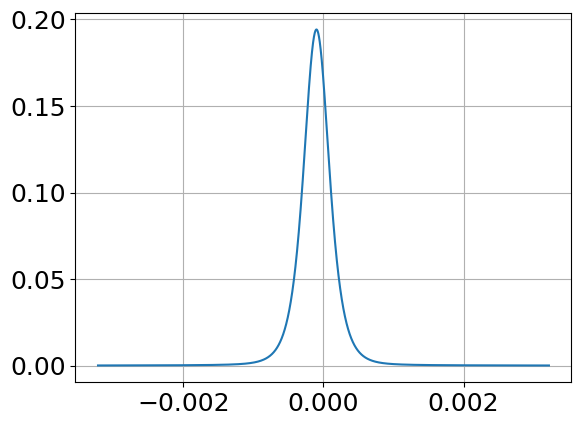

In [100]:
plt.plot(trap[15, 0], trap[15,1])

array([-0.10475576])

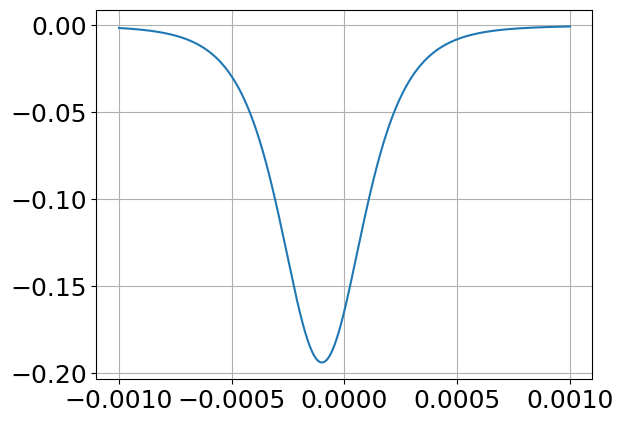

In [101]:
test = red_system(trap)  
test.setIons(np.array([[[-300.0e-6],[0],[0]],], dtype=np.float64))
voltage = np.zeros((16, 1))
voltage[15, 0] = -1
test.volt = voltage
#print(minimize(lambda t: test.getPot(np.array([t]), 0)[0], 300e-6))

x = np.linspace(-1e-3, 1e-3, 1000)
plt.plot(x, test.getPot(x, 0))
test.getPot(np.array([100e-6]), 0)

108


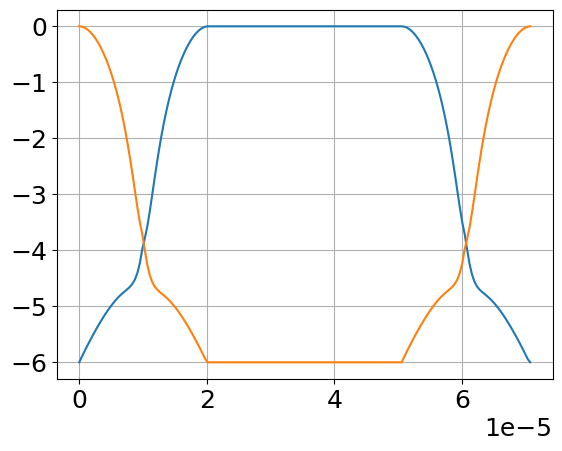

In [102]:
redramp = np.load('redramp.npy')
plt.plot(redramp[0], redramp[1])
plt.plot(redramp[0], redramp[2])
print(redramp.shape[1])

# Use Case

Filter Setup

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.patches as patches
import matplotlib.colors as mcolors 


class FilterSimulation():

    def __init__(self):
        self.filter_constant = 0.0000175 # hardware constraint on filter
        self.time_step = 0.00000038 # DAQ time step constraint

    def filter(self):
        # load kernel:
        filter_kernel = np.load('filter_data.npy')
        samples = len(filter_kernel) # 300

        original_time = np.linspace(0, self.filter_constant, samples)

        target_samples = int(self.filter_constant / self.time_step) # 17.5 / 0.38 = 46
        compressed_time = np.linspace(0, self.filter_constant, target_samples) 

        # interpolate to get kernel to length 17.5 µs:
        interpolator = interp1d(original_time, filter_kernel, kind = 'cubic')
        compressed_kernel = interpolator(compressed_time)

        # get impulse response
        impulse_response = np.diff(compressed_kernel, prepend = 0)
        
        return impulse_response

    def pre_setup(self, waveform, waveform_size):
        if waveform[0] != 0:
            waveform -= waveform[0]

        # define time (x-axis) and waveform (y-axis):
        total_time = len(waveform) * self.time_step # 51 * 0.38 = 19.38
        time_array = np.linspace(0, total_time, len(waveform)) # 0 to 19.38 with 51 samples
        waveform *= waveform_size # scale voltages as needed

        return time_array, waveform

    def setup(self, time_array, waveform, compress, pad):
        compressed_time = time_array / compress
        dense_waveform = np.interp(time_array, compressed_time, waveform)
        mask = 0
        for i in range(0, len(compressed_time)):
            if time_array[i] <= compressed_time[-1]:
                mask += 1
            else:
                break
        masked_waveform = dense_waveform[:mask]
        original = np.pad(masked_waveform, pad_width = pad, mode = 'edge')
        time = np.arange(len(original)) * self.time_step

        return time, original

    def convolution(self, waveform):
        impulse_response = self.filter()
        filtered_waveform = np.convolve(waveform, impulse_response, mode = 'full')
        return filtered_waveform
    
    def interpolation(self, time, shift, filtered):
        interp_func = interp1d(shift, filtered, kind='cubic', bounds_error=False, fill_value="extrapolate")
        filtered_interp = interp_func(time)  # Now same length as time_original
        return filtered_interp
    
    def plotter(self, original, time, filtered, precompensated_unfiltered, precompensated_filtered):
        plt.figure()
        plt.plot(time, original, label = 'Original')
        plt.plot(time, filtered, label = 'Filtered')
        plt.plot(time, precompensated_unfiltered, label = 'Precompensated Unfiltered', linestyle = '--')
        plt.plot(time, precompensated_filtered, label = 'Precompensated Filtered', linestyle = '--')
        plt.title('Filter Waveforms')
        plt.xlabel('Time in µs')
        plt.ylabel('Voltage')
        plt.grid(True)
        plt.legend()
        plt.show()

    def scatter_plot(self, time, precompensated):
        plt.figure()
        plt.plot(time, precompensated, label = 'Full Plot', color = 'red')
        plt.scatter(time, precompensated, label = 'Scattered Plot', color = 'pink')
        plt.title('Precompensated Filtered Waveform')
        plt.xlabel('Time in µs')
        plt.ylabel('Voltage')
        plt.grid(True)
        plt.legend()
        plt.show()

    def precompensation(self, waveform, reg, pad):
        impulse_response = self.filter()
        total_length = max(len(impulse_response), len(waveform)) + 2 * pad

        left_pad = pad
        right_pad_ir = max(0, total_length - len(impulse_response) - pad)
        right_pad_waveform = max(0, total_length - len(waveform) - pad)

        ir_padded = np.pad(impulse_response, (left_pad, right_pad_ir), mode='constant')
        waveform_padded = np.pad(waveform, (left_pad, right_pad_waveform), mode='constant', constant_values = waveform[-1])

        G = fft(ir_padded)
        h_t = waveform_padded
        h_w = fft(h_t)

        G_magnitude = np.abs(G) # amplitude attenuation
        G_phase = np.angle(G) # phase shift

        # Tikhonov regularization: prevents division by zeros or near-zeros
        regularized_magnitude = G_magnitude / (G_magnitude**2 + reg)
        regularized_G = regularized_magnitude * np.exp(-1j * G_phase)

        f_w = h_w * regularized_G
        f_t = np.real(ifft(f_w))

        return f_t

    def trimming(self, original, precompensated, pad):
        for i in range(0, int(pad*0.5)):
            precompensated[i] = original[0]     
        for i in range(len(precompensated) - int(pad*0.5), len(precompensated)):
            precompensated[i] = original[-1]
        return precompensated
    
class Optimize():
    
    def __init__(self):
        self.padding_range = list(range(10, 31))
        self.reg_exponents = list(range(-6, 0))   
        self.reg_coeff = list(range(1, 8))
        self.compression_range = list(range(1, 2))
        
        self.lower_voltage_bound = -40
        self.upper_voltage_bound = 40
        self.time_step = 0.00000038

        self.alpha = 1.00 # <-- weight of max abs error
        self.beta = 0.01 # <-- weight of length

    def optimizer(self, time_array, waveform):
        best_penalty = float('inf')
        best_params = (None, None, None, None, None) # compression, padding, reg_strength, penalty, bounds
        all_best_params = []
        reg_array = []
        
        # generate all possibilities:
        for k, compress in enumerate(self.compression_range):
            for i, pad in enumerate(self.padding_range):
                for j, reg in enumerate(self.reg_exponents):
                    for l, coeff in enumerate(self.reg_coeff):
                        reg_strength = coeff * 10 ** reg

                        time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

                        # filtering:
                        precompensated = FilterSimulation().precompensation(original, reg_strength, pad)
                        precompensated = precompensated[:len(original)]
                        precompensated = FilterSimulation().trimming(original, precompensated, pad)
                        precompensated_filtered = FilterSimulation().convolution(precompensated)
                        shift_p = np.arange(len(precompensated_filtered)) * self.time_step
                        precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)
                        
                        # results:
                        error = np.max(np.abs(original - precompensated_filtered))
                        length_penalty = (2 * pad + len(original)) / compress
                        penalty = self.alpha * error + self.beta * length_penalty #self.alpha * error + self.beta * pad - self.gamma * compress

                        # print(f'Pad: {pad}, Compress: {compress}, Reg: {reg_strength}, Error: {error}')
                        
                        if np.max(precompensated) > self.upper_voltage_bound or np.min(precompensated) < self.lower_voltage_bound:
                            bounds = 1
                        else:
                            bounds = 0

                        if bounds == 0:
                            if penalty < best_penalty:
                                best_penalty = penalty
                                best_params = (compress, pad, reg_strength, penalty, bounds)
                                all_best_params.append(best_params)

                        if len(reg_array) < (len(self.reg_coeff) * len(self.reg_exponents)):
                            reg_array.append(reg_strength)

        valid_results = [res for res in all_best_params if res[4] == 0]
        if not valid_results:
            print("No valid results found within bounds! Returning least-penalty violating case.")
            best_params = min(all_best_params, key = lambda x: x[3])
        else:
            best_params = min(valid_results, key = lambda x: x[3])
        
        return best_params, reg_array
    
    def get_grids(self, time_array, waveform, best_params):
        compression_grids = {}
        compress = best_params[0]

        error_grid = np.full((len(self.padding_range), len(self.reg_exponents) * len(self.reg_coeff)), np.nan)
        bounds_grid = np.full((len(self.padding_range), len(self.reg_exponents) * len(self.reg_coeff)), np.nan)
        
        for i, pad in enumerate(self.padding_range):
            reg_index = 0
            for j, reg in enumerate(self.reg_exponents):
                for l, coeff in enumerate(self.reg_coeff):
                    reg_strength = coeff * 10 ** reg

                    time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

                    # filtering:
                    precompensated = FilterSimulation().precompensation(original, reg_strength, pad)
                    precompensated = precompensated[:len(original)]
                    precompensated = FilterSimulation().trimming(original, precompensated, pad)
                    precompensated_filtered = FilterSimulation().convolution(precompensated)
                    shift_p = np.arange(len(precompensated_filtered)) * self.time_step
                    precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

                    # results:
                    error = np.max(np.abs(original - precompensated_filtered))
                    length_penalty = (2 * pad + len(original)) / compress
                    penalty = self.alpha * error + self.beta * length_penalty

                    if np.max(precompensated) > self.upper_voltage_bound or np.min(precompensated) < self.lower_voltage_bound:
                        bounds = 1
                    else:
                        bounds = 0

                    error_grid[i, reg_index] = error
                    bounds_grid[i, reg_index] = bounds
                    reg_index += 1

        compression_grids[compress] = (error_grid.copy(), bounds_grid.copy())
        return compression_grids

                        
    def heatmap(self, best_params, compression_grids, reg_array):
        compress = best_params[0]
        pad = best_params[1]
        reg = best_params[2]
        error_grid, bounds_grid = compression_grids[compress]

        plt.figure(figsize = (12, 7))
        
        cmap = sns.color_palette("coolwarm", as_cmap = True)
        ax = sns.heatmap(
            error_grid,
            yticklabels = self.padding_range[::10],  # compression values
            cmap = cmap,
            cbar_kws = {'label': 'Error (in V)'},
            annot = False, # set to true for values displayed on each cell
            fmt = '.2e', # scientific notation format for annotations
        )

        # gray overlay where bounds = 1:
        overlay = np.where(bounds_grid == 1, 1, np.nan)  # 1 where out of bounds, NaN elsewhere
        sns.heatmap(
            overlay,
            mask = np.isnan(overlay),
            cmap = mcolors.ListedColormap([(0.5, 0.5, 0.5, 0.8)]),  # gray with alpha = 0.8
            cbar = False,
            ax = ax
        )

        plt.title(f'Heatmap at Compression x{compress}')
        plt.xlabel('Regularization Strength')
        plt.ylabel('Padding Samples')

        n_yticks = 7
        ytick_positions = np.linspace(0, len(self.padding_range) - 1, n_yticks, dtype = int)
        plt.yticks(ytick_positions, [self.padding_range[i] for i in ytick_positions])
        
        n_xticks = 12
        xtick_positions = np.linspace(0, len(reg_array) - 1, n_xticks, dtype = int)
        labels = [f'{coeff}e{exponent}' for exponent in self.reg_exponents for coeff in self.reg_coeff]
        selected_labels = [labels[i] for i in xtick_positions]
        plt.xticks(xtick_positions, selected_labels, rotation = 45)

        ax.grid(False)
        rect = patches.Rectangle((reg_array.index(reg), self.padding_range.index(pad)), 1, 1, fill = False, edgecolor = 'gold', lw = 3)
        ax.add_patch(rect)
        plt.tight_layout()
        plt.show()

    def error_plotter(self, time, original, precompensated_filtered, best_params):
        rmse = np.sqrt(mean_squared_error(original, precompensated_filtered)) # average error across all points (precompensation is off by about -- volts)
        pointwise_error = np.abs(original - precompensated_filtered) # worst deviation point in the waveform 

        compress = best_params[0]
        pad = best_params[1]
        reg = best_params[2]
        best_penalty = best_params[3]
        
        print('----------------------------------------------------')
        print(f'The best padding is:', pad)
        print(f'The best regularization is: {reg:.0e}')
        print(f'The best compression is: {compress}')
        print(f'The best penalty is: {best_penalty}')
        print(f"Root Mean Squared Error (RMSE): {rmse:.3f} V")
        print(f"Max Absolute Error: {np.max(pointwise_error):.3f} V")

        # absolute error over time:
        plt.plot(time, pointwise_error, color='red', label='|Original - Precompensated Filtered|')
        plt.title('Error between Original and Precompensated Filtered Signal')
        plt.xlabel('Time in µs')
        plt.ylabel('Absolute Error (V)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def tradeoff_plot(self, time_array, waveform, best_params):
        error_array = []
        compression_array = []
        pad = best_params[1]
        reg = best_params[2]
        
        for k, compress in enumerate(self.compression_range):
            time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

            # filtering:
            precompensated = FilterSimulation().precompensation(original, reg, pad)
            precompensated = precompensated[:len(original)]
            precompensated = FilterSimulation().trimming(original, precompensated, pad)
            precompensated_filtered = FilterSimulation().convolution(precompensated)
            shift_p = np.arange(len(precompensated_filtered)) * self.time_step
            precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)
            
            # results:
            error = np.max(np.abs(original - precompensated_filtered))
            compression_array.append(compress)
            error_array.append(error)

        plt.plot(compression_array, error_array)
        plt.xlabel("Compression")
        plt.ylabel("Max Absolute Error")
        plt.title("Compression vs. Max Error")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Waveform Setup

In [111]:
redramp = np.load('redramp.npy')

time_array = redramp[0].copy()
waveform_1 = redramp[1].copy()
waveform_2 = redramp[2].copy()

### Waveform 1:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


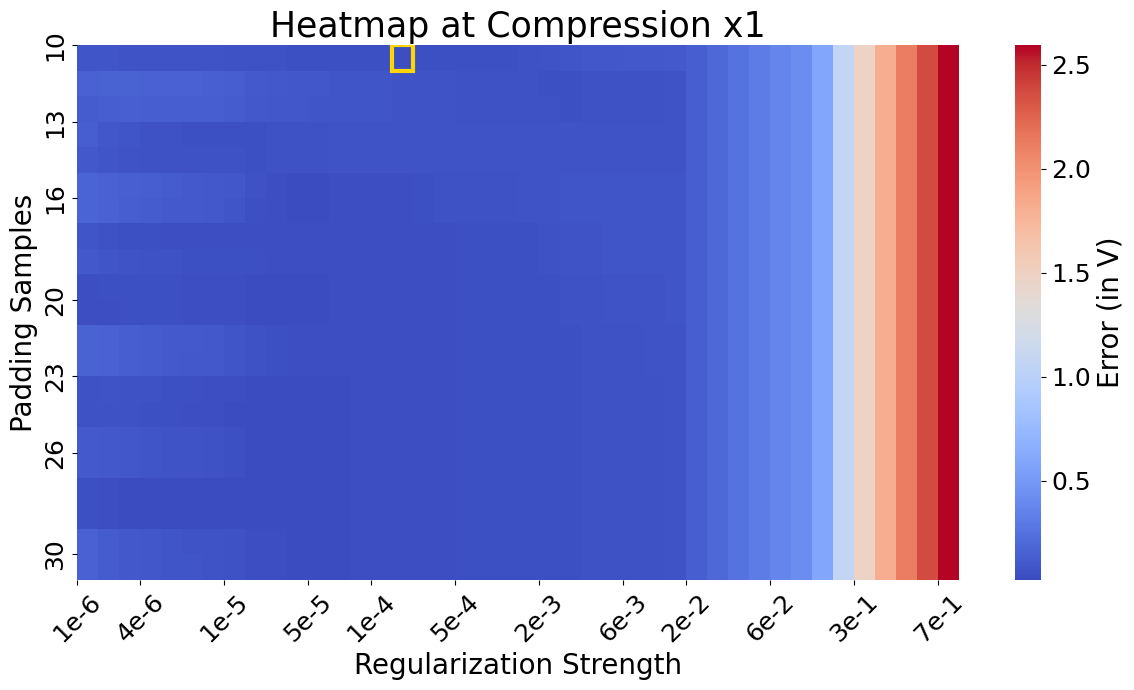

----------------------------------------------------
The best padding is: 10
The best regularization is: 2e-04
The best compression is: 1
The best penalty is: 1.521870773434027
Root Mean Squared Error (RMSE): 0.011 V
Max Absolute Error: 0.042 V


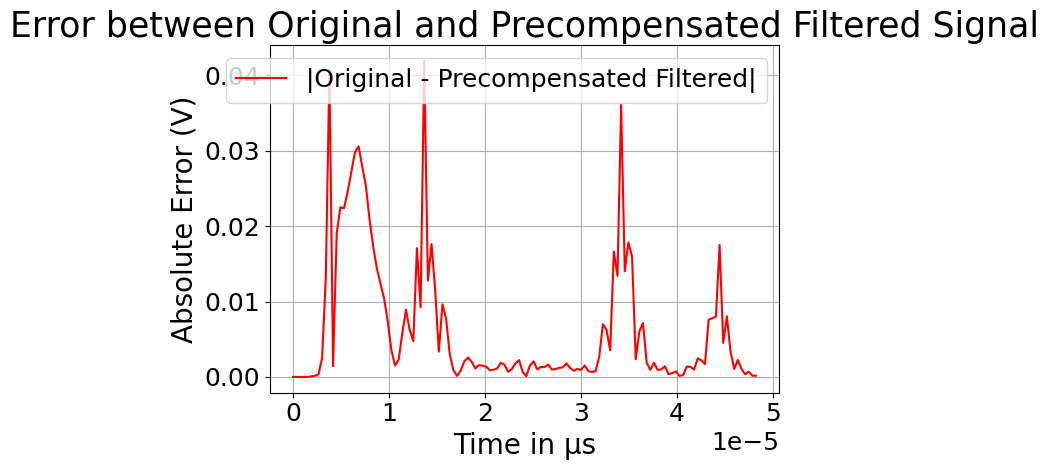

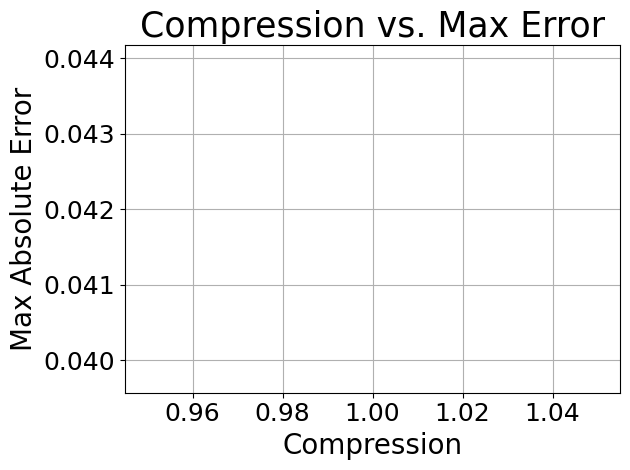

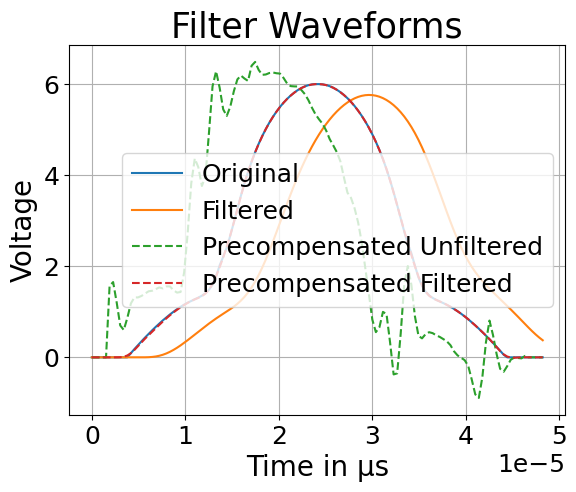

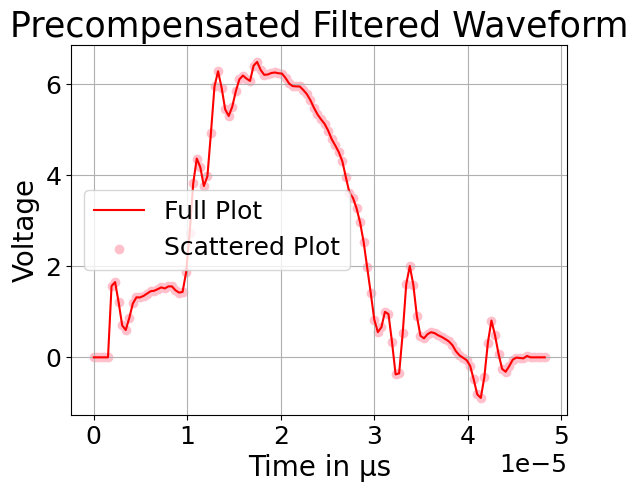

There are 128 points total.


In [112]:
# input data:
waveform_size = 1 # not already normalized
time_step = 0.00000038 # DAQ lower limit

# waveform data:
waveform = waveform_1
time_array, waveform = FilterSimulation().pre_setup(waveform, waveform_size)

# optimization:
best_params, reg_array = Optimize().optimizer(time_array, waveform)
compress = best_params[0]
pad = best_params[1] 
reg = best_params[2]
error = best_params[3]

# setup waveform:
time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

# begin filter simulation:
# -- filtered
filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * time_step
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

# -- precompensated setup
precompensated = FilterSimulation().precompensation(original, reg, pad)
precompensated = precompensated[:len(original)]
precompensated = FilterSimulation().trimming(original, precompensated, pad)

# -- precompensated filtered
precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * time_step
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

# -- precompensated unfiltered
shift_p_unfiltered = np.arange(len(precompensated)) * time_step
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

# -- results:
compression_grids = Optimize().get_grids(time_array, waveform, best_params)
Optimize().heatmap(best_params, compression_grids, reg_array)
Optimize().error_plotter(time, original, precompensated_filtered, best_params) # <-- error checker
Optimize().tradeoff_plot(time_array, waveform, best_params)
FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)
FilterSimulation().scatter_plot(time, precompensated)
print(f'There are', len(original),'points total.')

# setup for redramp preparation:
waveform_1 = original

### Waveform 2:

In [95]:
# waveform data:
waveform = waveform_2
time_array, waveform = FilterSimulation().pre_setup(waveform, waveform_size)

# already optimized (by waveform 1):
compress = best_params[0]
pad = best_params[1] 
reg = best_params[2]
error = best_params[3]

# setup waveform:
time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

# begin filter simulation:
# -- filtered
filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * time_step
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

# -- precompensated setup
precompensated = FilterSimulation().precompensation(original, reg, pad)
precompensated = precompensated[:len(original)]
precompensated = FilterSimulation().trimming(original, precompensated, pad)

# -- precompensated filtered
precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * time_step
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

# -- precompensated unfiltered
shift_p_unfiltered = np.arange(len(precompensated)) * time_step
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

print(f'There are', len(original),'points total.')

# setup for redramp preparation:
waveform_2 = original

There are 55 points total.


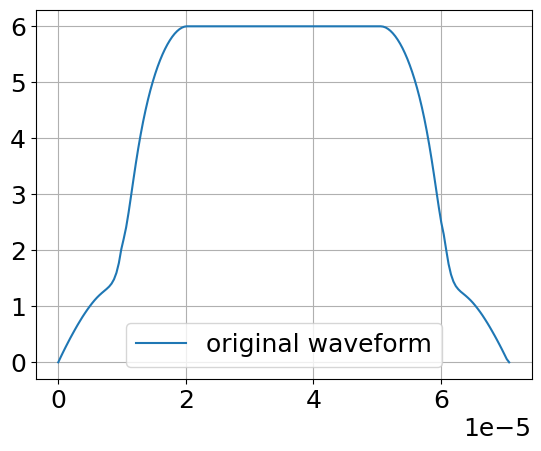

In [106]:
original_redramp = np.load('redramp.npy')
plt.plot(original_redramp[0], original_redramp[1]+6, label = 'original waveform')
plt.legend()
plt.grid(True)
plt.show()